In [1]:
import numpy as np
import tqdm 

import matplotlib.pyplot as plt
import matplotlib as mpl
import sys

sys.path.append('../pipeline_scripts/')
from pipeline_main import pipeline, dist

sys.path.insert(0, '/groups/astro/kxm508/codes/osyris/src')
import osyris

# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)

from osyris.plot.direction import get_direction

In [2]:
print(sys.path)

['/groups/astro/kxm508/codes/osyris/src', '/groups/astro/kxm508/codes/dispatch2/utilities/python', '/lustre/hpc/astro/kxm508/codes/python_dispatch/OSYRIS', '/software/astro/python/repository', '/software/astro/anaconda/anaconda3-2021.05/lib/python38.zip', '/software/astro/anaconda/anaconda3-2021.05/lib/python3.8', '/software/astro/anaconda/anaconda3-2021.05/lib/python3.8/lib-dynload', '', '/groups/astro/kxm508/.local/lib/python3.8/site-packages', '/software/astro/anaconda/anaconda3-2021.05/lib/python3.8/site-packages', '/software/astro/anaconda/anaconda3-2021.05/lib/python3.8/site-packages/locket-0.2.1-py3.8.egg', '/software/astro/anaconda/anaconda3-2021.05/lib/python3.8/site-packages/IPython/extensions', '/lustre/hpc/astro/kxm508/.ipython', '../pipeline_scripts/', '/groups/astro/kxm508/.osyris']


In [3]:
osyris.__file__

'/groups/astro/kxm508/codes/osyris/src/osyris/__init__.py'

In [4]:
def to_osyris(self, ivs = 'd', view = 200, dz = None, resolution = 400, viewpoint = None, ivs_unit = 'g/cm^3', make_plot = False):
    selection_radius =  (np.sqrt(2 * (0.5*view)**2) * 1.2)/ self.au_length # Not all data is needed to be read for a single slap of data
    self.recalc_L()
    self.calc_trans_xyz()
    print('Looping over DISPATCH data to extract data at highest level')
    pp = [p for p in self.sn.patches if np.linalg.norm(p.trans_ppos, axis = 0) < selection_radius and p.level > 5]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    patch_cartcoor = []
    patch_ds = []
    patch_values = []
    for p in tqdm.tqdm(sorted_patches):
        nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.trans_ppos - p.trans_ppos)**2).sum() < ((p.size)**2).sum()/12]
        if len(leafs) == 8: continue
        to_extract = np.ones(p.n, dtype=bool)
        for lp in leafs:
            leaf_extent = np.vstack((lp.trans_ppos - 0.5 * lp.size, lp.trans_ppos + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.trans_xyz > leaf_extent[:, 0, None, None, None]) & (p.trans_xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool

        new_xyz = p.trans_xyz[:,to_extract].T
        new_value = p.var(ivs)[to_extract].T

        patch_ds.extend(p.ds[0] * np.ones(len(new_value)))
        patch_cartcoor.extend(new_xyz.tolist())
        patch_values.extend(new_value.tolist())
    
    patch_ds = np.asarray(patch_ds)
    patch_cartcoor = np.asarray(patch_cartcoor)
    patch_values = np.asarray(patch_values)

    print('Setting up Osyris data structure')
    ds = osyris.Dataset(nout = None)
    # overwrite units
    ds.meta['unit_l'] = self.sn.scaling.l
    ds.meta['unit_t'] = self.sn.scaling.t
    ds.meta['unit_d'] = self.sn.scaling.d
    ds.set_units()
    ds.meta["ndim"] = 3
    
    if viewpoint == None: viewpoint = self.L
    to_view = osyris.Vector(x=viewpoint[0],y=viewpoint[1],z=viewpoint[2])

    ds['amr'] = osyris.Datagroup()
    ds['amr']['dx'] = osyris.Array(patch_ds*self.sn.scaling.l, unit='cm')
    ds['amr']['position'] = osyris.Vector(x=patch_cartcoor[:,0]*self.sn.scaling.l, y=patch_cartcoor[:,1]*self.sn.scaling.l, z=patch_cartcoor[:,2]*self.sn.scaling.l, unit='cm')
    ds['hydro'] = osyris.Datagroup()
    ds['hydro']['density'] = osyris.Array(patch_values, unit='dimensionless')

    view *= osyris.units('au')
    if dz == None: dz = 0.1 * view
    else: dz *= osyris.units('au')
    center = osyris.Vector(x=0,y=0,z=0,unit='au')

    ret = osyris.map({"data": ds['hydro']['density'], "norm": "log"}, dx=view, dz = dz, origin=center, resolution=resolution, plot=make_plot, direction='z')

    plot_height = dz / osyris.units('au') * self.sn.cgs.au
    print(plot_height)
    return ret.layers[0]['data'], ds.meta["ndim"] #/ plot_height

pipeline.to_osyris = to_osyris

In [5]:
data = pipeline(snap =  355, run = 'sink13fmr05', sink_id = 13)
data.recalc_L(radius=5)
data.calc_trans_xyz()

Initialising patch data
Assigning relative cartesian velocities and coordinates to all cells
Assigning masses to all cells
Calculating adiabatic index γ and pressure (polytropic) for all cells


100%|██████████| 4165/4165 [00:06<00:00, 683.71it/s]


Converged mean angular momentum vector after 1 iteration(s)
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:01<00:00, 3482.56it/s]


In [12]:

new_x = np.dot(data.rotation_matrix, np.array([1,0,0]))
new_y = np.dot(data.rotation_matrix, np.array([0,1,0]))

dir_vecs = {}
dir_vecs['pos_u'] = osyris.Vector(x=new_x[0],  y = new_x[1], z=new_x[2])
dir_vecs['pos_v'] = osyris.Vector(x=new_y[0], y = new_y[1], z=new_y[2])
dir_vecs['normal'] = osyris.Vector(x=data.L[0], y=data.L[1], z=data.L[2])
#lst=np.array([new_x[0],new_x[1],new_x[2]])
dir_vecs2 = dir_vecs.copy()
dir_vecs2['normal'] = dir_vecs['pos_u']
dir_vecs2['pos_u'] = dir_vecs['pos_v']
dir_vecs2['pos_v'] = dir_vecs['normal']


#view_vecs['x'] = osyris.Vector(x=new_x[0],y=new_x[1],z=new_x[2])
#view_vecs['y'] = osyris.Vector(x=new_y[0],y=new_y[1],z=new_y[2])
#view_vecs = osyris.Vector(x=self.L[0],y=self.L[1],z=self.L[2])

rold = np.array([0,1,0])
Lnorm = data.L
xper = rold[0] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[0]
yper = rold[1] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[1]
zper = rold[2] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[2]

rnew = np.array([xper,yper,zper])
rnew
L = osyris.Vector(data.L[0], data.L[1], data.L[2])
new_x_osyris = osyris.Vector(new_x[0], new_x[1], new_x[2])
np.cross(new_x, new_y), data.L


(array([ 0.99738577, -0.07183967,  0.00779062]),
 array([ 0.99738577, -0.07183967,  0.00779062]))

In [7]:
ivs = 'd'; view = 200; dz = None; resolution = 400; viewpoint = None; ivs_unit = 'g/cm^3'; make_plot = False
selection_radius =  (np.sqrt(2 * (0.5*view)**2) * 2)/ data.au_length # Not all data is needed to be read for a single slap of data

print('Looping over DISPATCH data to extract data at highest level')
pp = [p for p in data.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
w= np.array([p.level for p in pp]).argsort()[::-1]
sorted_patches = [pp[w[i]] for i in range(len(pp))]

patch_cartcoor = []
patch_ds = []
patch_values = []
for p in tqdm.tqdm(sorted_patches):
    nbors = [data.sn.patchid[i] for i in p.nbor_ids if i in data.sn.patchid]
    children = [ n for n in nbors if n.level == p.level + 1]
    leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]
    if len(leafs) == 8: continue
    to_extract = np.ones(p.n, dtype=bool)
    for lp in leafs:
        leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
        covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
        to_extract *= covered_bool

    new_xyz = p.rel_xyz[:,to_extract].T
    new_value = p.var(ivs)[to_extract].T

    patch_ds.extend(p.ds[0] * np.ones(len(new_value)))
    patch_cartcoor.extend(new_xyz.tolist())
    patch_values.extend(new_value.tolist())

patch_ds = np.asarray(patch_ds)
patch_cartcoor = np.asarray(patch_cartcoor)
patch_values = np.asarray(patch_values)

print('Setting up Osyris data structure')
ds = osyris.Dataset(nout = None)
# overwrite units
ds.meta['unit_l'] = data.sn.scaling.l
ds.meta['unit_t'] = data.sn.scaling.t
ds.meta['unit_d'] = data.sn.scaling.d
ds.set_units()
ds.meta["ndim"] = 3


ds['amr'] = osyris.Datagroup()
ds['amr']['dx'] = osyris.Array(patch_ds*data.sn.scaling.l, unit='cm')
ds['amr']['position'] = osyris.Vector(x=patch_cartcoor[:,0]*data.sn.scaling.l, y=patch_cartcoor[:,1]*data.sn.scaling.l, z=patch_cartcoor[:,2]*data.sn.scaling.l, unit='cm')
ds['hydro'] = osyris.Datagroup()
ds['hydro']['density'] = osyris.Array(patch_values, unit='dimensionless')

view *= osyris.units('au')
if dz == None: dz = 0.1 * view
else: dz *= osyris.units('au')
center = osyris.Vector(x=0,y=0,z=0,unit='au')


Looping over DISPATCH data to extract data at highest level


  0%|          | 0/1411 [00:00<?, ?it/s]

100%|██████████| 1411/1411 [00:06<00:00, 210.15it/s]


Setting up Osyris data structure


In [8]:
dir_vecs

{'pos_u': '' Value: 0.013, 0.071, -0.997 [] (), {x,y,z},
 'pos_v': '' Value: 0.071, 0.995, 0.072 [] (), {x,y,z},
 'normal': '' Value: 0.997, -0.072, 0.008 [] (), {x,y,z}}

In [9]:
isinstance(dir_vecs, dict)

True

In [14]:
ret_L = osyris.map({"data": ds['hydro']['density'], "norm": "log"}, dx=view, dz = dz, origin=center, resolution=resolution, direction=dir_vecs2, plot=make_plot)

In [42]:
ret_L = osyris.map({"data": ds['hydro']['density'], "norm": "log"}, dx=view, dz = dz, origin=center, resolution=resolution, direction=L, plot=make_plot)

In [45]:

ret_newx = osyris.map({"data": ds['hydro']['density'], "norm": "log"}, dx=view, dz = dz, origin=center, resolution=resolution, direction=new_x_osyris, plot=make_plot)


plot_height = dz / osyris.units('au') * data.sn.cgs.au
print(plot_height)
density2 =  ret.layers[0]['data']  #/ plot_height, ret

299200000000000.0 dimensionless


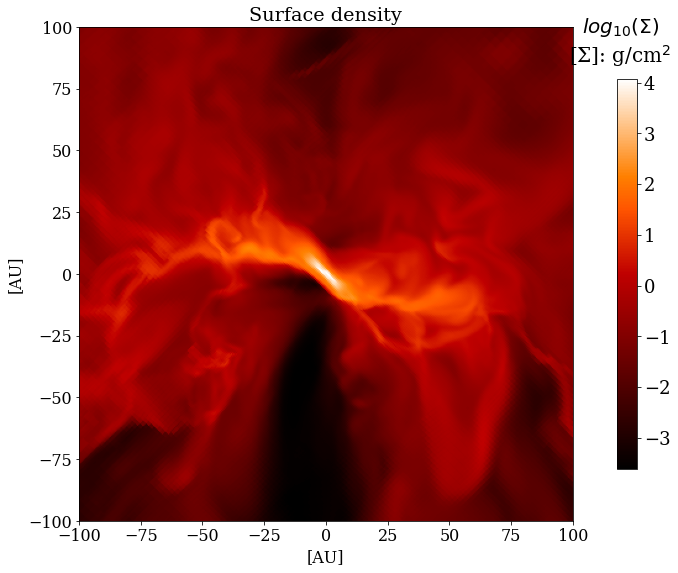

In [46]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10(ret_newx.layers[0]['data'] * data.cgs_density), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'gist_heat')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Surface density', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)

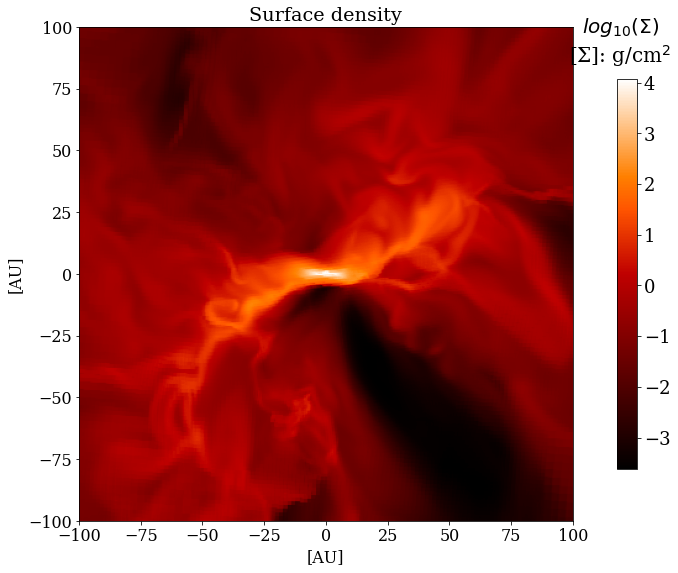

In [15]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10(ret_L.layers[0]['data'] * data.cgs_density), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'gist_heat')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Surface density', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)

In [212]:
def to_osyris2(self, ivs = 'd', view = 200, dz = None, resolution = 400, viewpoint = None, ivs_unit = 'g/cm^3', make_plot = False):
    selection_radius =  (np.sqrt(2 * (0.5*view)**2) * 2)/ self.au_length # Not all data is needed to be read for a single slap of data
    
    print('Looping over DISPATCH data to extract data at highest level')
    pp = [p for p in self.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    patch_cartcoor = []
    patch_ds = []
    patch_values = []
    for p in tqdm.tqdm(sorted_patches):
        nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]
        if len(leafs) == 8: continue
        to_extract = np.ones(p.n, dtype=bool)
        for lp in leafs:
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool

        new_xyz = p.rel_xyz[:,to_extract].T
        new_value = p.var(ivs)[to_extract].T

        patch_ds.extend(p.ds[0] * np.ones(len(new_value)))
        patch_cartcoor.extend(new_xyz.tolist())
        patch_values.extend(new_value.tolist())
    
    patch_ds = np.asarray(patch_ds)
    patch_cartcoor = np.asarray(patch_cartcoor)
    patch_values = np.asarray(patch_values)

    print('Setting up Osyris data structure')
    ds = osyris.Dataset(nout = None)
    # overwrite units
    ds.meta['unit_l'] = self.sn.scaling.l
    ds.meta['unit_t'] = self.sn.scaling.t
    ds.meta['unit_d'] = self.sn.scaling.d
    ds.set_units()
    ds.meta["ndim"] = 3
    
    self.calc_trans_xyz()
    new_x = np.dot(self.rotation_matrix, np.array([1,0,0]))
    new_y = np.dot(self.rotation_matrix, np.array([0,1,0]))
    
    view_vecs = {}
    view_vecs['pos_v'] = osyris.Vector(x=new_x[0],  y=new_x[1], z=new_x[2])
    view_vecs['pos_u'] = osyris.Vector(x=new_y[0],y=new_y[1],   z=new_y[2])
    view_vecs['normal'] = osyris.Vector(x=self.L[0],    y=self.L[1],    z=self.L[2])

    #view_vecs['x'] = osyris.Vector(x=new_x[0],y=new_x[1],z=new_x[2])
    #view_vecs['y'] = osyris.Vector(x=new_y[0],y=new_y[1],z=new_y[2])
    #view_vecs = osyris.Vector(x=self.L[0],y=self.L[1],z=self.L[2])

    rold = np.array([0,1,0])
    Lnorm = data.L
    xper = rold[0] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[0]
    yper = rold[1] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[1]
    zper = rold[2] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[2]

    rnew = np.array([xper,yper,zper])
    rnew


    view_vecs = osyris.Vector(x=new_x[0],y=new_x[1],z=new_x[2])

    ds['amr'] = osyris.Datagroup()
    ds['amr']['dx'] = osyris.Array(patch_ds*self.sn.scaling.l, unit='cm')
    ds['amr']['position'] = osyris.Vector(x=patch_cartcoor[:,0]*self.sn.scaling.l, y=patch_cartcoor[:,1]*self.sn.scaling.l, z=patch_cartcoor[:,2]*self.sn.scaling.l, unit='cm')
    ds['hydro'] = osyris.Datagroup()
    ds['hydro']['density'] = osyris.Array(patch_values, unit='dimensionless')

    view *= osyris.units('au')
    if dz == None: dz = 0.1 * view
    else: dz *= osyris.units('au')
    center = osyris.Vector(x=0,y=0,z=0,unit='au')

    ret = osyris.map({"data": ds['hydro']['density'], "norm": "log"}, dx=view, dz = dz, origin=center, resolution=resolution, direction=view_vecs, plot=make_plot)

    plot_height = dz / osyris.units('au') * self.sn.cgs.au
    print(plot_height)
    return ret.layers[0]['data']  #/ plot_height, ret

pipeline.to_osyris2 = to_osyris2

In [188]:
rold = np.array([1,0,0])
Lnorm = data.L
xper = rold[0] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[0]
yper = rold[1] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[1]
zper = rold[2] - (rold[0]*Lnorm[0] + rold[1]*Lnorm[1] + rold[2]*Lnorm[2]) * Lnorm[2]

rnew = np.array([xper,yper,zper])
rnew

array([0.15383927, 0.35368794, 0.07125721])

In [195]:
np.dot(rnew, data.L)

7.45931094670027e-17

In [209]:
data.calc_trans_xyz()
new_x = np.dot(data.rotation_matrix, np.array([1,0,0]))
new_y = np.dot(data.rotation_matrix, np.array([0,1,0]))

Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5875.61it/s]


In [211]:
np.dot(new_x, data.L), np.dot(new_y, data.L)

(1.8041124150158794e-16, -9.71445146547012e-17)

In [197]:
np.cross(np.array([0,1,0]), np.array([0,0,1]))

array([1, 0, 0])

In [196]:
np.cross(new_y, data.L), new_x

(array([ 0.08278795,  0.38338679, -0.91986995]),
 array([ 0.08278795,  0.38338679, -0.91986995]))

In [120]:
density, ds_ndim = data.to_osyris()

Converged mean angular momentum vector after 0 iteration(s)
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5661.79it/s]


Looping over DISPATCH data to extract data at highest level


100%|██████████| 1195/1195 [00:04<00:00, 255.99it/s]


Setting up Osyris data structure
299200000000000.0 dimensionless


In [192]:
density2 = data.to_osyris2()

Looping over DISPATCH data to extract data at highest level


  0%|          | 0/1411 [00:00<?, ?it/s]

100%|██████████| 1411/1411 [00:04<00:00, 292.82it/s]


Setting up Osyris data structure
Transforming old z-coordinate into mean angular momentum vector


100%|██████████| 4165/4165 [00:00<00:00, 5337.92it/s]


299200000000000.0 dimensionless


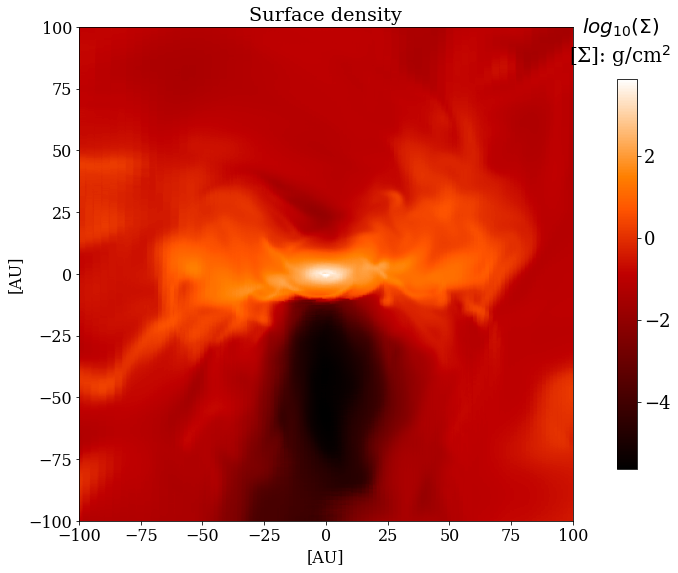

In [100]:
def to_osyris_ivs(self, variables, view = 200, dz = None, resolution = 400, viewpoint = None):
    selection_radius =  (np.sqrt(2 * (0.5*view)**2) * 1.2)/ self.au_length # Not all data is needed to be read for a single slap of data

    print('Looping over DISPATCH data to extract data at highest level')
    pp = [p for p in self.sn.patches if np.linalg.norm(p.rel_ppos, axis = 0) < selection_radius]
    w= np.array([p.level for p in pp]).argsort()[::-1]
    sorted_patches = [pp[w[i]] for i in range(len(pp))]

    patch_cartcoor = []
    patch_ds = []
    patch_values = {key: [] for key in range(len(variables))}
    self.osyris_ivs = {key: [] for key in range(len(variables))}
    for p in tqdm.tqdm(sorted_patches):
        nbors = [self.sn.patchid[i] for i in p.nbor_ids if i in self.sn.patchid]
        children = [ n for n in nbors if n.level == p.level + 1]
        leafs = [n for n in children if ((n.position - p.position)**2).sum() < ((p.size)**2).sum()/12]
        if len(leafs) == 8: continue
        to_extract = np.ones(p.n, dtype=bool)
        for lp in leafs:
            leaf_extent = np.vstack((lp.position - 0.5 * lp.size, lp.position + 0.5 * lp.size)).T
            covered_bool = ~np.all((p.xyz > leaf_extent[:, 0, None, None, None]) & (p.xyz < leaf_extent[:, 1, None, None, None]), axis=0)
            to_extract *= covered_bool

        #Looping over the data to extract from DISPATCH
        for i, ivs in enumerate(variables):
            new_value = p.var(ivs)[to_extract].T
            patch_values[i].extend(new_value.tolist())
        
        #Extracting the position and cellsize data each is fixed across all data
        new_xyz = p.rel_xyz[:,to_extract].T
        patch_ds.extend(p.ds[0] * np.ones(len(new_value)))
        patch_cartcoor.extend(new_xyz.tolist())
        
    
    patch_ds = np.asarray(patch_ds)
    patch_cartcoor = np.asarray(patch_cartcoor)
    for key in patch_values:
        patch_values[key] = np.array(patch_values[key])

    print('Setting up Osyris data structure')
    ds = osyris.Dataset(nout = None)
    # overwrite units
    ds.meta['unit_l'] = self.sn.scaling.l
    ds.meta['unit_t'] = self.sn.scaling.t
    ds.meta['unit_d'] = self.sn.scaling.d
    ds.set_units()
    ds.meta["ndim"] = 3

    if viewpoint == None: viewpoint = self.L
    to_view = osyris.Vector(x=viewpoint[0],y=viewpoint[1],z=viewpoint[2])

    view *= osyris.units('au')
    if dz == None: dz = 0.1 * view
    else: dz *= osyris.units('au')
    center = osyris.Vector(x=0,y=0,z=0,unit='au')
    plot_height = dz / osyris.units('au') * self.sn.cgs.au

    ds['amr'] = osyris.Datagroup()
    ds['amr']['dx'] = osyris.Array(patch_ds*self.sn.scaling.l, unit='cm')
    ds['amr']['position'] = osyris.Vector(x=patch_cartcoor[:,0]*self.sn.scaling.l, y=patch_cartcoor[:,1]*self.sn.scaling.l, z=patch_cartcoor[:,2]*self.sn.scaling.l, unit='cm')
    ds['hydro'] = osyris.Datagroup()
    for i, ivs in enumerate(variables):
        ds['hydro'][f'{i}'] = osyris.Array(patch_values[i], unit = 'dimensionless')
        ret = osyris.map({"data": ds['hydro'][f'{i}'], "norm": "log"}, dx=view, dz = dz, origin=center, resolution=resolution, direction=to_view, plot=False)
        if ivs == 'd': self.osyris_ivs[i] = ret.layers[0]['data']
        else:
            self.osyris_ivs[i] = ret.layers[0]['data'] / plot_height

pipeline.to_osyris_ivs = to_osyris_ivs

In [40]:
# List containing the ivs string values to extract from patches
variable = ['(bx**2 + by**2 + bz**2)**0.5', 'd', '((px**2+py**2+pz**2)**0.5 / d)**0.5']
for i, ivs in enumerate(variable):
    print(i, ivs)

0 (bx**2 + by**2 + bz**2)**0.5
1 d
2 ((px**2+py**2+pz**2)**0.5 / d)**0.5


In [99]:
data.to_osyris_ivs(variables=variable)

NameError: name 'variable' is not defined

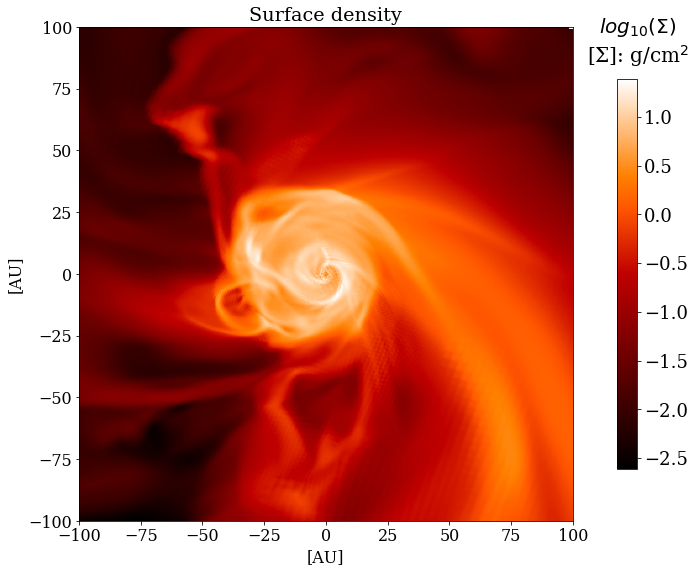

In [42]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10(data.osyris_ivs[1] * data.cgs_density), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'gist_heat')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(Σ)$\n[Σ]: g/cm$^2$', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Surface density', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)

# The strength of the magnetic field seems a bit high - could be a bug somewhere

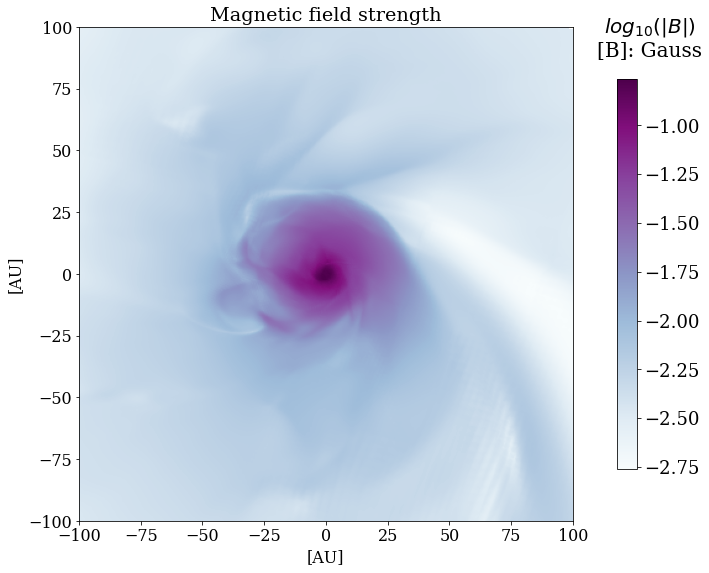

In [43]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10((data.osyris_ivs[0]) *data.sn.scaling.b), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'BuPu')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(|B|)$\n[B]: Gauss', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Magnetic field strength', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)

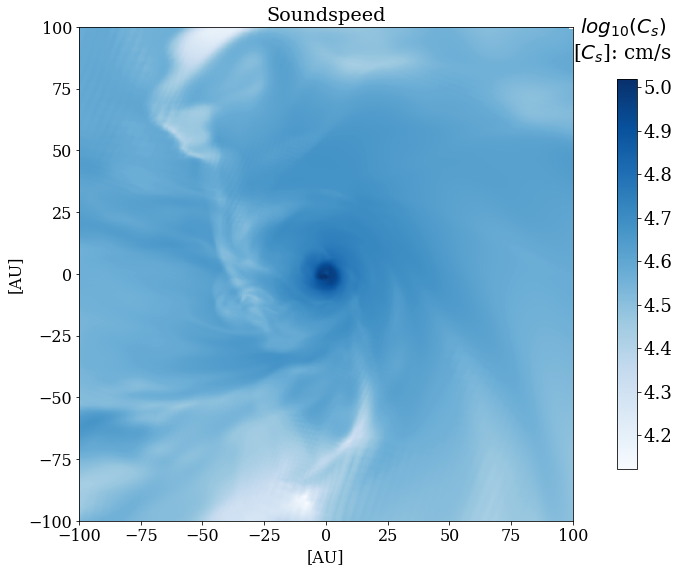

In [44]:
fig, axs = plt.subplots(figsize = (10, 10))
cs = axs.imshow(np.log10((data.osyris_ivs[2]) * data.cms_velocity), extent = (-100, 100, -100, 100), origin ='lower', cmap = 'Blues')
cbar = fig.colorbar(cs, ax = axs, fraction = 0.035, pad = 0.08);
cbar.ax.xaxis.set_label_coords(-10, -10)
cbar.set_label('$log_{10}(C_s)$\n[$C_s$]: cm/s', labelpad = -50, y = 1.16, rotation = 0, fontsize = 20)
axs.set(title = 'Soundspeed', ylabel = '[AU]', xlabel = '[AU]')
cbar.ax.tick_params(labelsize=18)